# Part 4: Checking the NN Performance

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

To not forget anything later, let us globaly define the number of events in the MG sample

In [2]:
inputfile = 'data/madminer_example_100k.h5'
nsamples = 100000

## 8. Optimization: ML settings

The setup of the MLForge includes a set of input parameters. So far we have just used the default setup. Now we will see how changing this setup effects the performance of the Machine Learning the the accuracy of the score estimation. 

### 7a) Run the Data Augmentation and Machine Learning part

First, we once again augment the dataand machine learning part again.

In [3]:
sa = SampleAugmenter(inputfile, debug=False)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='train'
)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='test',
    switch_train_test_events=True
)

10:33  
10:33  ------------------------------------------------------------
10:33  |                                                          |
10:33  |  MadMiner v0.1.0                                         |
10:33  |                                                          |
10:33  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:33  |                                                          |
10:33  ------------------------------------------------------------
10:33  
10:33  Loading data from data/madminer_example_100k.h5
10:33  Found 2 parameters:
10:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:33  Found 6 benchmarks:
10:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:33     morphing_basis_vector_2: CWL2 = -5.87e+00, CPWL2 = 49.22
10:33     morphing_basis_vector_3: CWL2 = 41.02, CPWL2 = -4.58e+01


### 8b) Define set of settings

In the following, let us define a set of setting. Later we will choose random combinations of these setting options, train the MLForge, evaulate the Fisher Information and compare the results. In particular, we consider the following settings:
- number of epochs
- number of hidden layers of the NN
- number of neurons per hidden layer 
- activation function of the neurons
- initial learning rate
- ratio of initial and final learning rate

In [4]:
choices_epochs = [50,100,200] 
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 

choices_validation = [None]
choices_trainer = ['amsgrad'] 
choices_regularization = [None]  

### 8c) Run the scan

We will store the results of the scan in a separate file. If it already exists, let's just append to it.

In [5]:
usesummaryfile='data/samples_scan/summary.npy'
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

Define the number of scans that is supposed to be performed 

In [6]:
nscan=10

Let us now run the scan. It consists of the following steps

- choose settings randomly 
- create/run MLForge
- evaluate Fisher Info and Mean Squared Error between truth and estimated scores
- save results to summary file 

Note that the run will be the default setting

In [7]:
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    
    #Setup/train/save ensemble
    forge = MLForge()
    if iscan==0:
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy'
        )   
    else: 
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            initial_lr=this_learning[0],
            final_lr=this_learning[1]
        )
    modelsavefile='./models/samples_scan/setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    
    #Fisher Info 
    fisher = FisherInformation(inputfile, debug=False)
    fi_mean_test , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_test.npy'
    )
    fi_mean_train , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_train.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load('./data/samples_scan/t_xz_test.npy')
    t_ml_test=forge.evaluate('./data/samples_scan/x_test.npy')
    t_pl_train=np.load('./data/samples_scan/t_xz_train.npy')
    t_ml_train=forge.evaluate('./data/samples_scan/x_train.npy')
    t_mse_test = mean_squared_error(t_pl_test,t_ml_test)
    t_mse_train = mean_squared_error(t_pl_train,t_ml_train)
    
    #Save everything
    newelement= [iscan,
                 index_epochs,index_nhidden,index_nneuron,
                 index_activation,index_lrinitial,index_lrratio,
                 np.linalg.det(fi_mean_test),
                 t_mse_test,
                 np.linalg.det(fi_mean_train),
                 t_mse_train,
                ]
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

10:33  Starting training
10:33    Method:                 sally
10:33    Training data: x at ./data/samples_scan/x_train.npy
10:33                   t_xz (theta0) at  ./data/samples_scan/t_xz_train.npy
10:33    Features:               all
10:33    Method:                 sally
10:33    Hidden layers:          (100, 100)
10:33    Activation function:    tanh
10:33    Batch size:             128
10:33    Trainer:                amsgrad
10:33    Epochs:                 50
10:33    Learning rate:          0.001 initially, decaying to 0.0001
10:33    Validation split:       None
10:33    Early stopping:         True
10:33    Scale inputs:           True
10:33    Shuffle labels          False
10:33    Regularization:         None
10:33  Loading training data
10:33  Found 50000 samples with 2 parameters and 23 observables
10:33  Rescaling inputs
10:34  Creating model for method sally
10:34  Training model


Do Run Number  0  out of  10


10:34    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
10:34    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
10:34    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
10:34    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
10:34    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
10:34    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
10:34    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
10:34    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
10:34    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
10:34    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
10:34  Finished training
10:34  Loading data from data/madminer_example_100k.h5
10:34  Found 2 parameters:
10:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:34  Found 6 benchmarks:
10:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:34     morphing_basis_vector_

Do Run Number  1  out of  10


10:35    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
10:36    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
10:36    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
10:37    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
10:37    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
10:38    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
10:38    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
10:39    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
10:39    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
10:39    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
10:39  Finished training
10:39  Loading data from data/madminer_example_100k.h5
10:39  Found 2 parameters:
10:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:39     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:39  Found 6 benchmarks:
10:39     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:39     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:39     morphing_basis_vecto

Do Run Number  2  out of  10


10:40    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
10:40    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
10:40    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
10:41    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
10:41    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
10:41    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
10:41    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
10:41    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
10:41    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
10:42    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
10:42  Finished training
10:42  Loading data from data/madminer_example_100k.h5
10:42  Found 2 parameters:
10:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:42     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:42  Found 6 benchmarks:
10:42     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:42     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:42     morphing_basis_vector_

Do Run Number  3  out of  10


10:42    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
10:42    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
10:42    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
10:42    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
10:42    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
10:42    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
10:43    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
10:43    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
10:43    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
10:43    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
10:43  Finished training
10:43  Loading data from data/madminer_example_100k.h5
10:43  Found 2 parameters:
10:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:43     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:43  Found 6 benchmarks:
10:43     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:43     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:43     morphing_basis_vector_

Do Run Number  4  out of  10


10:44    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
10:44    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
10:45    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
10:45    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
10:46    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
10:46    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
10:47    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
10:48    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
10:48    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
10:49    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
10:49  Finished training
10:49  Loading data from data/madminer_example_100k.h5
10:49  Found 2 parameters:
10:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:49  Found 6 benchmarks:
10:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:49     morphing_basis_

Do Run Number  5  out of  10


10:49    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
10:49    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
10:49    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
10:50    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
10:50  Finished training
10:50  Loading data from data/madminer_example_100k.h5
10:50  Found 2 parameters:
10:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:50     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:50  Found 6 benchmarks:
10:50     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:50     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:50     morphing_basis_vecto

Do Run Number  6  out of  10


10:51    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
10:51    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
10:51    Epoch 15: train loss 0.0000 (mse_score: 0.0000)
10:51    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
10:52    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
10:52  Finished training
10:52  Loading data from data/madminer_example_100k.h5
10:52  Found 2 parameters:
10:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:52  Found 6 benchmarks:
10:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:52     morphing_basis_vector_

Do Run Number  7  out of  10


10:53    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
10:53    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
10:53    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
10:54    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
10:54    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
10:54    Epoch 120: train loss 0.0008 (mse_score: 0.0008)
10:54    Epoch 140: train loss 0.0008 (mse_score: 0.0008)
10:55    Epoch 160: train loss 0.0008 (mse_score: 0.0008)
10:55    Epoch 180: train loss 0.0008 (mse_score: 0.0008)
10:55    Epoch 200: train loss 0.0008 (mse_score: 0.0008)
10:55  Finished training
10:55  Loading data from data/madminer_example_100k.h5
10:55  Found 2 parameters:
10:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:55     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:55  Found 6 benchmarks:
10:55     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:55     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:55     morphing_basis_

Do Run Number  8  out of  10


10:56    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
10:56    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
10:57    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
10:57    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
10:57    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
10:57    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
10:58    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
10:58    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
10:58    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
10:59    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
10:59  Finished training
10:59  Loading data from data/madminer_example_100k.h5
10:59  Found 2 parameters:
10:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:59  Found 6 benchmarks:
10:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:59     morphing_basis_

Do Run Number  9  out of  10


11:00    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
11:00    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
11:01    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
11:01    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
11:01    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
11:02    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
11:02    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
11:02    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
11:03    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
11:03    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
11:03  Finished training
11:03  Loading data from data/madminer_example_100k.h5
11:03  Found 2 parameters:
11:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:03  Found 6 benchmarks:
11:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:03     morphing_basis_

### 8c) Plot results

We can now visualize our results as a scatter plot in the Means Squared Error (MSE) vs Fisher Information plane. The dashed line corresponds to the truth level Fisher Information.

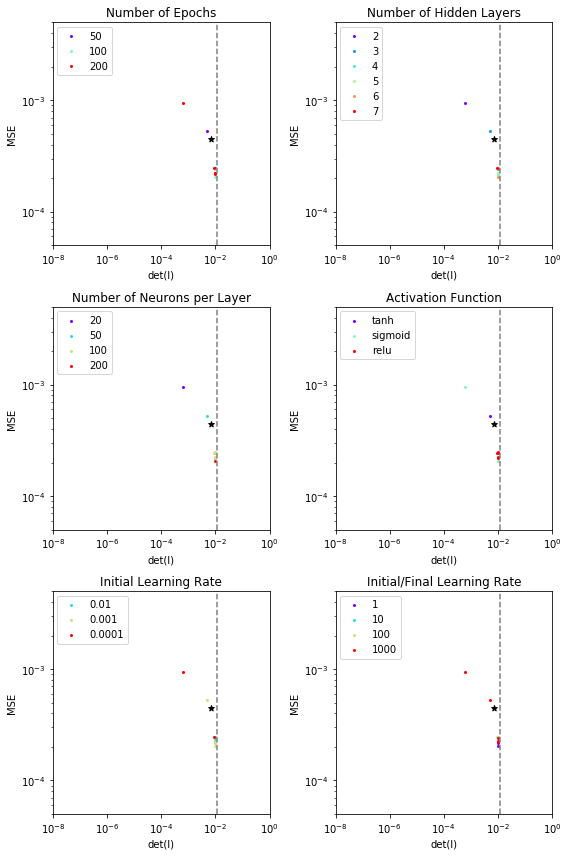

In [8]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[5*10**(-5),.005]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
f.set_size_inches(8,12)

# choices_nepochs
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_epochs)))
for i in range(len(choices_epochs)):
    thisdata=sublist(data,1,i)
    if len(thisdata)!=0:
        ax1.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_epochs[i]))
ax1.scatter(data[0,7], data[0,8],color='black',marker="*")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Number of Epochs')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    if len(thisdata)!=0:
        ax2.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,7], data[0,8],color='black',marker="*")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    if len(thisdata)!=0:
        ax3.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,7], data[0,8],color='black',marker="*")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    if len(thisdata)!=0:
        ax4.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,7], data[0,8],color='black',marker="*")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,5,i)
    if len(thisdata)!=0:
        ax5.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax5.scatter(data[0,7], data[0,8],color='black',marker="*")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Initial Learning Rate')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,6,i)
    if len(thisdata)!=0:
        ax6.scatter(thisdata[:,7], thisdata[:,8],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax6.scatter(data[0,7], data[0,8],color='black',marker="*")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial/Final Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

#######
#Plot
plt.tight_layout()
plt.show()

### 8d) Compare test and train samples

Let us also, as cross check, compare the MSE and Fisher Information of the test amnd train samples

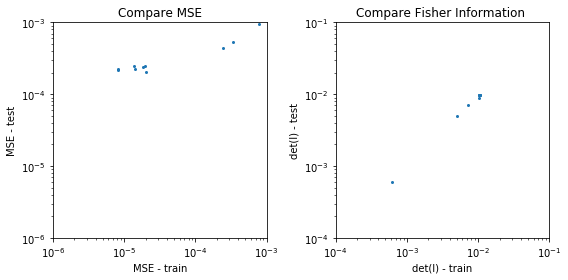

In [16]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangefi=[10**(-4),10**(-1)]
myrangemse=[10**(-6),0.001]
mysize=4
f, (ax1,ax2) = plt.subplots(1,2)
f.set_size_inches(8,4)

# MSE
ax1.scatter(data[:,10], data[:,8],s=mysize,alpha=1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('MSE - train')
ax1.set_ylabel('MSE - test')
ax1.set_xlim(myrangemse)
ax1.set_ylim(myrangemse)
ax1.set_title('Compare MSE')

# Fisher
ax2.scatter(data[:,9], data[:,7],s=mysize,alpha=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I) - train')
ax2.set_ylabel('det(I) - test')
ax2.set_xlim(myrangefi)
ax2.set_ylim(myrangefi)
ax2.set_title('Compare Fisher Information ')

#######
#Plot
plt.tight_layout()
plt.show()